In [6]:
# Set pathways and initialize model
import os
import re
import time
import torch

import numpy as np
import pandas as pd

from scipy.spatial import KDTree
from cellpose import models, core, io

# set pathways to test files
# Paths to annotated test data
base_dir = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/images/'
output_root = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/cellpose_output'

# create output directory if it doesn't already exist
if not os.path.exists(output_root):
    os.mkdir(output_root)

# have cellpose log run
io.logger_setup()

# initialize model
use_GPU = core.use_gpu()
model = models.Cellpose(gpu = use_GPU, model_type = 'nuclei')


2022-11-17 11:55:44,755 [INFO] WRITING LOG OUTPUT TO /home/elyse/.cellpose/run.log
2022-11-17 11:55:46,425 [INFO] ** TORCH CUDA version installed and working. **
2022-11-17 11:55:46,427 [INFO] ** TORCH CUDA version installed and working. **
2022-11-17 11:55:46,427 [INFO] >>>> using GPU
2022-11-17 11:55:46,428 [INFO] >> nuclei << model set to be used
2022-11-17 11:55:46,607 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)


In [7]:
# Load custom functions
from bs4 import BeautifulSoup
from collections import defaultdict

# function to turn .xml files into x, y, z coordinates
def get_locations(path):
    # read xml file
    with open(path, 'r') as f:
        data = f.read()
    # get xml data in iterable format
    markers = BeautifulSoup(data, features='xml').find_all('Marker')
    cell_loci = []
    # iterate and output marker locations
    for marker in markers:
        coords = re.findall('[0-9]+', marker.text)
        coords = [int(x) for x in coords]
        cell_loci.append(coords)
    
    return cell_loci

# prediction and annotation overlap and build dataframe for validation metrics
# max distance a prediction can be off and still count as cell. very conservative at 1 px
def annot_pred_overlap(blocks, max_dist, type_2D):

    metric_df = pd.DataFrame(columns = ['x', 'y', 'z', 'block', 'annotated', 'predicted'])

    for key in blocks.keys():
    
        # get annotated data (not alwats a reject file)
        annot_detect = np.asarray(blocks[key]['detect'])
            
        try:
            annot_reject = np.asarray(blocks[key]['reject'])
            type_reject = np.ones((len(annot_reject), 1)) * 2
        
            annot_points = np.concatenate((annot_detect, annot_reject), axis = 0)
            annot_types = np.concatenate((np.ones((len(annot_detect), 1)),
                                          np.ones((len(annot_reject), 1)) * 2), axis = 0)
        except:
            annot_points = annot_detect.copy()
            annot_types = np.ones((len(annot_detect), 1))

        # get predicted data
        pred_detect = np.asarray(blocks[key]['pred_detect_' + type_2D])
        pred_reject = np.asarray(blocks[key]['pred_reject_' + type_2D])
    
        if len(pred_reject) > 0:
            pred_points = np.concatenate((pred_detect, pred_reject), axis = 0)
            pred_types = np.concatenate((np.ones((len(pred_detect), 1)),
                                     np.ones((len(pred_reject), 1)) * 2), axis = 0)
        else:
            pred_points = pred_detect.copy()
            pred_types = np.ones((len(pred_detect), 1))
        
        # create annotation and prediction tree for comparison
        annot_tree = KDTree(annot_points)
        pred_tree = KDTree(pred_points)
    
        # returns: for each element in annot_tree[i], indexes[i] is a list of indecies within distance r from pred_tree
        indexes = annot_tree.query_ball_tree(pred_tree, r = max_dist)
        pred_id = np.zeros((len(annot_types), 1))
        pred_extra = np.zeros((len(pred_types), 1))
    
        # get the index and type for all annotated cells and id predicted cells that were not annotated
        for c, idx in enumerate(indexes):
            if len(idx) > 0:
                pred_id[c] = pred_types[idx[0]]
                pred_extra[idx[0]] = 1
    
        pred_id[pred_id == 0] = 3
        data_array = np.concatenate((annot_points,
                                     np.ones((len(annot_points), 1)) * int(key),
                                     annot_types,
                                     pred_id), axis = 1)
    
        # get location and type of predicted cells that where not annotated
        pred_extra_loc, _ = np.where(pred_extra == 0)
        if len(pred_extra_loc) > 0:
            curr_points = pred_points[pred_extra_loc[:], :]
            curr_types = pred_types[pred_extra_loc[:], :]
            pred_array = np.concatenate((curr_points,
                                        np.ones((len(curr_points), 1)) * int(key),
                                        np.ones((len(curr_points), 1)) * 3,
                                        curr_types), axis = 1)
        
            # add to annot array
            data_array = np.vstack((data_array, pred_array))

        # create dataframes                                         
        curr_df = pd.DataFrame(data_array, columns = ['x', 'y', 'z', 'block', 'annotated', 'predicted'])
        metric_df = pd.concat((metric_df, curr_df))
    return metric_df


In [8]:
# Get annotated data and image file paths
blocks = defaultdict(dict)

# loop through base directory and collect all data from "block_#" subfolders
for root, dirs, files in os.walk(base_dir):
    if 'block' in root: 
        for file in files:
            try:
                block_num = re.findall('[0-9]', file)[0]
            except:
                continue
            if 'signal' in file:
                blocks[block_num]['signal'] = os.path.join(root, file)
            elif 'background' in file:
                blocks[block_num]['background'] = os.path.join(root, file)
            elif 'detect' in file:
                blocks[block_num]['detect'] = get_locations(os.path.join(root, file))
            else:
                blocks[block_num]['reject'] = get_locations(os.path.join(root, file))

# print info on blocks        
for key in blocks.keys():
    try:
        rejected = len(blocks[key]['reject'])
    except:
        rejected = 0
    print('Pulled annotation data for block {0}: {1} cells and {2} noncells.'.format(str(key), len(blocks[key]['detect']), rejected))

Pulled annotation data for block 4: 2168 cells and 0 noncells.
Pulled annotation data for block 1: 1751 cells and 2 noncells.
Pulled annotation data for block 3: 410 cells and 5 noncells.
Pulled annotation data for block 2: 1641 cells and 2 noncells.


In [9]:
# There are 3 ways to run 3D Cellpose. The first 2 are exrapolating 2D to 3D
# This is very time consuming if ytou do not GPU access
# The Third way is using new Cellpose3D repo in other script
import skimage.io
from skimage.measure import regionprops

# Set parameters
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# channels = [0,0] # IF YOU HAVE GRAYSCALE
channels = [0,0]
prob_thresh = 0.9
stitch_thresh = 0.5
diameter = 9 # unit = px
min_size = 60
detect_times = defaultdict(int)

for method in ['flow', 'stitch']:
    start_detect = time.time()
    for key in blocks.keys():
        for ch in ['signal', 'background']:
            fname = os.path.basename(blocks[key][ch])[:-4]
            img = skimage.io.imread(blocks[key][ch])
            
            
            if method == 'flow':
                masks, flows, styles, diams = model.eval(img, channels = channels, diameter = diameter, cellprob_threshold = prob_thresh, 
                                                         do_3D = True, min_size = min_size)
            elif method == 'stitch':
                masks, flows, styles, diams = model.eval(img, channels = channels, diameter = diameter, cellprob_threshold = prob_thresh, 
                                                         do_3D = False, stitch_threshold = stitch_thresh)

            # get centroids from masks. see: https://github.com/MouseLand/cellpose/issues/337
            centroids = []
            candidates = regionprops(masks)
            for c in range(len(candidates)):
                location = [int(x) for x in candidates[c]['centroid']]
                centroids.append(location[::-1])
        
            if ch == 'signal':
                blocks[key]['pred_detect_' + method] = centroids
            else:
                blocks[key]['pred_reject_' + method] = centroids
            
            # save masks and flows
            output_path = os.path.join(output_root, method)

            # create output directory if it doesn't already exist
            if not os.path.exists(output_path):
                os.mkdir(output_path)
            
            # save masks as tif 
            io.save_masks(img, masks, flows, blocks[key][ch], png = False, tif = True, channels = channels, 
                          save_flows = True, save_outlines = True, savedir = output_path)
            
            # save all data for plotting
            io.masks_flows_to_seg(img, masks, flows, diams, os.path.join(output_path, fname), channels=None)

    detect_times[method] = time.time() - start_detect


2022-11-17 11:56:20,010 [INFO] ~~~ FINDING MASKS ~~~
2022-11-17 11:56:20,102 [INFO] multi-stack tiff read in as having 150 planes 1 channels
2022-11-17 11:56:21,739 [INFO] running YX: 150 planes of size (350, 350)
2022-11-17 11:56:36,811 [INFO] 100%|##########| 75/75 [00:14<00:00,  5.05it/s]
2022-11-17 11:56:38,401 [INFO] running ZY: 350 planes of size (150, 350)
2022-11-17 11:56:53,718 [INFO] 100%|##########| 88/88 [00:15<00:00,  5.83it/s]
2022-11-17 11:56:56,157 [INFO] running ZX: 350 planes of size (150, 350)
2022-11-17 11:57:11,631 [INFO] 100%|##########| 88/88 [00:15<00:00,  5.77it/s]
2022-11-17 11:57:13,146 [INFO] network run in 52.95s
2022-11-17 11:57:26,160 [INFO] masks created in 13.01s
2022-11-17 11:57:27,903 [INFO] >>>> TOTAL TIME 67.89 sec
2022-11-17 11:57:30,318 [INFO] ~~~ FINDING MASKS ~~~
2022-11-17 11:57:30,390 [INFO] multi-stack tiff read in as having 150 planes 1 channels
2022-11-17 11:57:32,068 [INFO] running YX: 150 planes of size (350, 350)
2022-11-17 11:57:45,965 

In [10]:
# get time to run each method
for method in ['flow', 'stitch']:
    print('Using ' + method + ' method for 2D to 3D')
    for key in blocks.keys():
        print('Classified {0} cells and {1} noncells for annocation block {2}.'.format(len(blocks[key]['pred_detect_' + method]), 
                                                                                       len(blocks[key]['pred_reject_' + method]), 
                                                                                       str(key)))

    print('Detection and Classification via ' + method + ' took {0} seconds.\n'.format(detect_times[method]))

Using flow method for 2D to 3D
Classified 1768 cells and 3 noncells for annocation block 4.
Classified 1459 cells and 1 noncells for annocation block 1.
Classified 396 cells and 49 noncells for annocation block 3.
Classified 1393 cells and 0 noncells for annocation block 2.
Detection and Classification via flow took 467.4492976665497 seconds.

Using stitch method for 2D to 3D
Classified 2384 cells and 9 noncells for annocation block 4.
Classified 1964 cells and 17 noncells for annocation block 1.
Classified 208 cells and 166 noncells for annocation block 3.
Classified 1804 cells and 30 noncells for annocation block 2.
Detection and Classification via stitch took 205.42547225952148 seconds.



In [12]:
# Identify prediction and annotation overlap and build dataframe for validation metrics
# Key: 1: signal that is detected and considered to be a cell
#      2: signal that is detected but found to be noise and rejected
#      3: singal that is annotated but not predicted to be signal
from pycm import ConfusionMatrix
import warnings

#since using different algorithm more flexibility in distance may be needed
perf_metrics = []

for i in range(10):
    dist = i + 1
    flow_df = annot_pred_overlap(blocks, dist, 'flow')
    stitch_df = annot_pred_overlap(blocks, dist, 'stitch')
    cm_flow = ConfusionMatrix(flow_df['annotated'].values, flow_df['predicted'].values, classes = [1.0, 2.0, 3.0])
    cm_stitch = ConfusionMatrix(stitch_df['annotated'].values, stitch_df['predicted'].values, classes = [1.0, 2.0, 3.0])
    perf_metrics.extend([[cm_flow.class_stat['PPV'][1.0], cm_stitch.class_stat['PPV'][1.0], dist],
                        [cm_flow.class_stat['TPR'][1.0], cm_stitch.class_stat['TPR'][1.0], dist],
                        [cm_flow.class_stat['F1'][1.0], cm_stitch.class_stat['F1'][1.0], dist]])

# ignores numpy.where() warning
warnings.simplefilter(action = 'ignore', category = FutureWarning)

performance = np.asarray(perf_metrics)
performance = np.where(performance == 'None', 0, performance)

Top F1 Scores for flow detection: 0.8943338437978561 and stitch detection: 0.8092916984006093


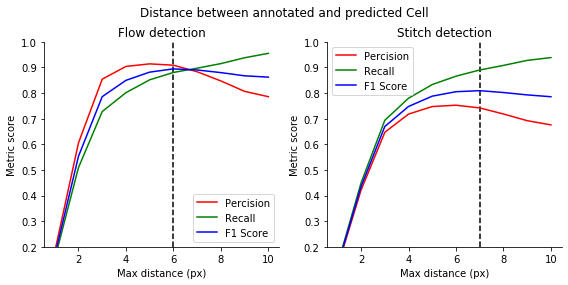

In [13]:
# Plot relationship between distance and performance metrics
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

colors = ['r', 'g', 'b']
mets = ['Percision', 'Recall', 'F1 Score']

opt_flow, opt_stitch = np.argmax(performance[2::3, 0]), np.argmax(performance[2::3, 1])

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.suptitle('Distance between annotated and predicted Cell')

for c, method in enumerate(['Flow', 'Stitch']):
    for i in range(3):
        sns.lineplot(x = performance[i::3, 2], y = performance[i::3, c], color = colors[i], label = mets[i], ax = ax[c], zorder = i+2)
        ax[c].set_xlabel('Max distance (px)')
        ax[c].set_ylabel('Metric score')
        ax[c].set_title(method + ' detection')
        ax[c].set_ylim(0.2, 1)
    
    if c == 0:
        ax[c].axvline(x = performance[2::3, 2][opt_flow], color = 'k', linestyle = '--', zorder = 1)
    else:
        ax[c].axvline(x = performance[2::3, 2][opt_stitch], color = 'k', linestyle = '--', zorder = 1)
        
sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])

print('Top F1 Scores for flow detection: {0} and stitch detection: {1}'.format(performance[2::3, 0][opt_flow], performance[2::3, 1][opt_stitch]))

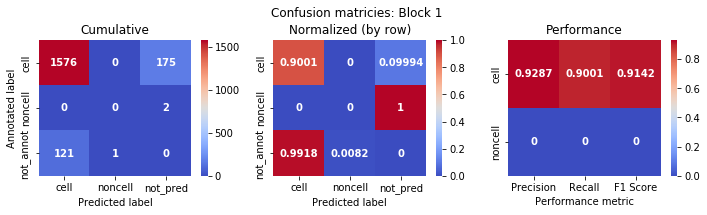

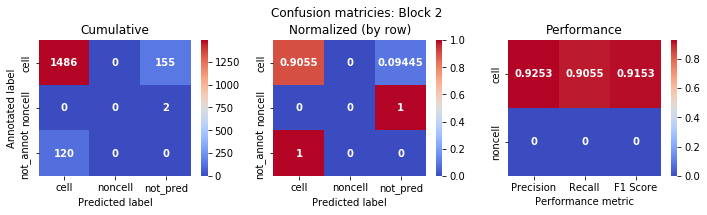

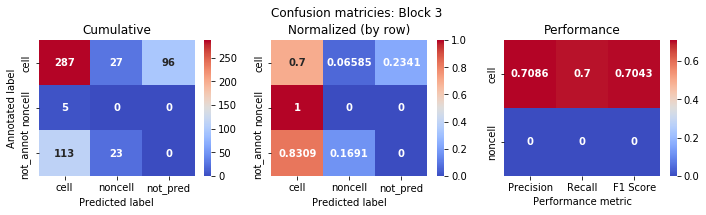

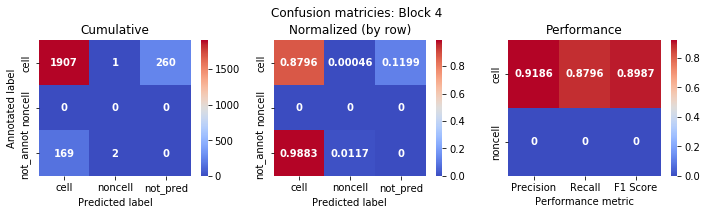

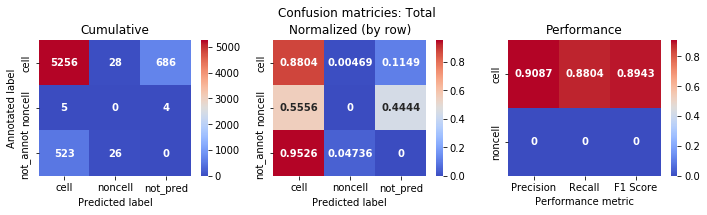

In [14]:
# Classification Metrix Plots
dist = performance[2::3, 2][opt_flow]
metric_df = annot_pred_overlap(blocks, dist, 'flow')
# Plot cumulative, Row normalized, and Performance for each block as well as total
for i in range(int(metric_df['block'].max()) + 1):
    fig, ax = plt.subplots(1, 3, figsize = (10, 3))
    
    if i < metric_df['block'].max():
        block_df = metric_df.loc[metric_df['block'] == i + 1, :]
        cm = ConfusionMatrix(block_df['annotated'].values, block_df['predicted'].values, classes = [1.0, 2.0, 3.0])
        fig.suptitle('Confusion matricies: Block ' + str(i + 1))
    else:
        cm = ConfusionMatrix(metric_df['annotated'].values, metric_df['predicted'].values, classes = [1.0, 2.0, 3.0])
        fig.suptitle('Confusion matricies: Total')
    
    for j in range(3):
        if j == 0:
            cm_df = pd.DataFrame(cm.to_array(normalized = False), columns = ['cell', 'noncell', 'not_pred'], index = ['cell', 'noncell', 'not_annot'])
            ax[j].set_title('Cumulative')
        elif j == 1:
            cm_df = pd.DataFrame(cm.to_array(normalized = True), columns = ['cell', 'noncell', 'not_pred'], index = ['cell', 'noncell', 'not_annot'])
            ax[j].set_title('Normalized (by row)')
        else:
            perf_array = np.asarray([[cm.class_stat['PPV'][k], cm.class_stat['TPR'][k], cm.class_stat['F1'][k]] for k in [1.0, 2.0]])
            perf_array = np.where(perf_array == 'None', 0, perf_array)
            cm_df = pd.DataFrame(perf_array.astype(float), columns = ['Precision', 'Recall', 'F1 Score'], index = ['cell', 'noncell'])
            ax[j].set_title('Performance')
            
        sns.heatmap(cm_df, annot = True, cmap = 'coolwarm', fmt = '.4g', annot_kws = {'fontweight': 'heavy'}, ax = ax[j])
        
        if j == 0:
            ax[j].set_ylabel('Annotated label')
        
        if j != 2:
            ax[j].set_xlabel('Predicted label')
        else:
            ax[j].set_xlabel('Performance metric')
            
    fig.tight_layout(rect=[0, 0, 1, 0.95])

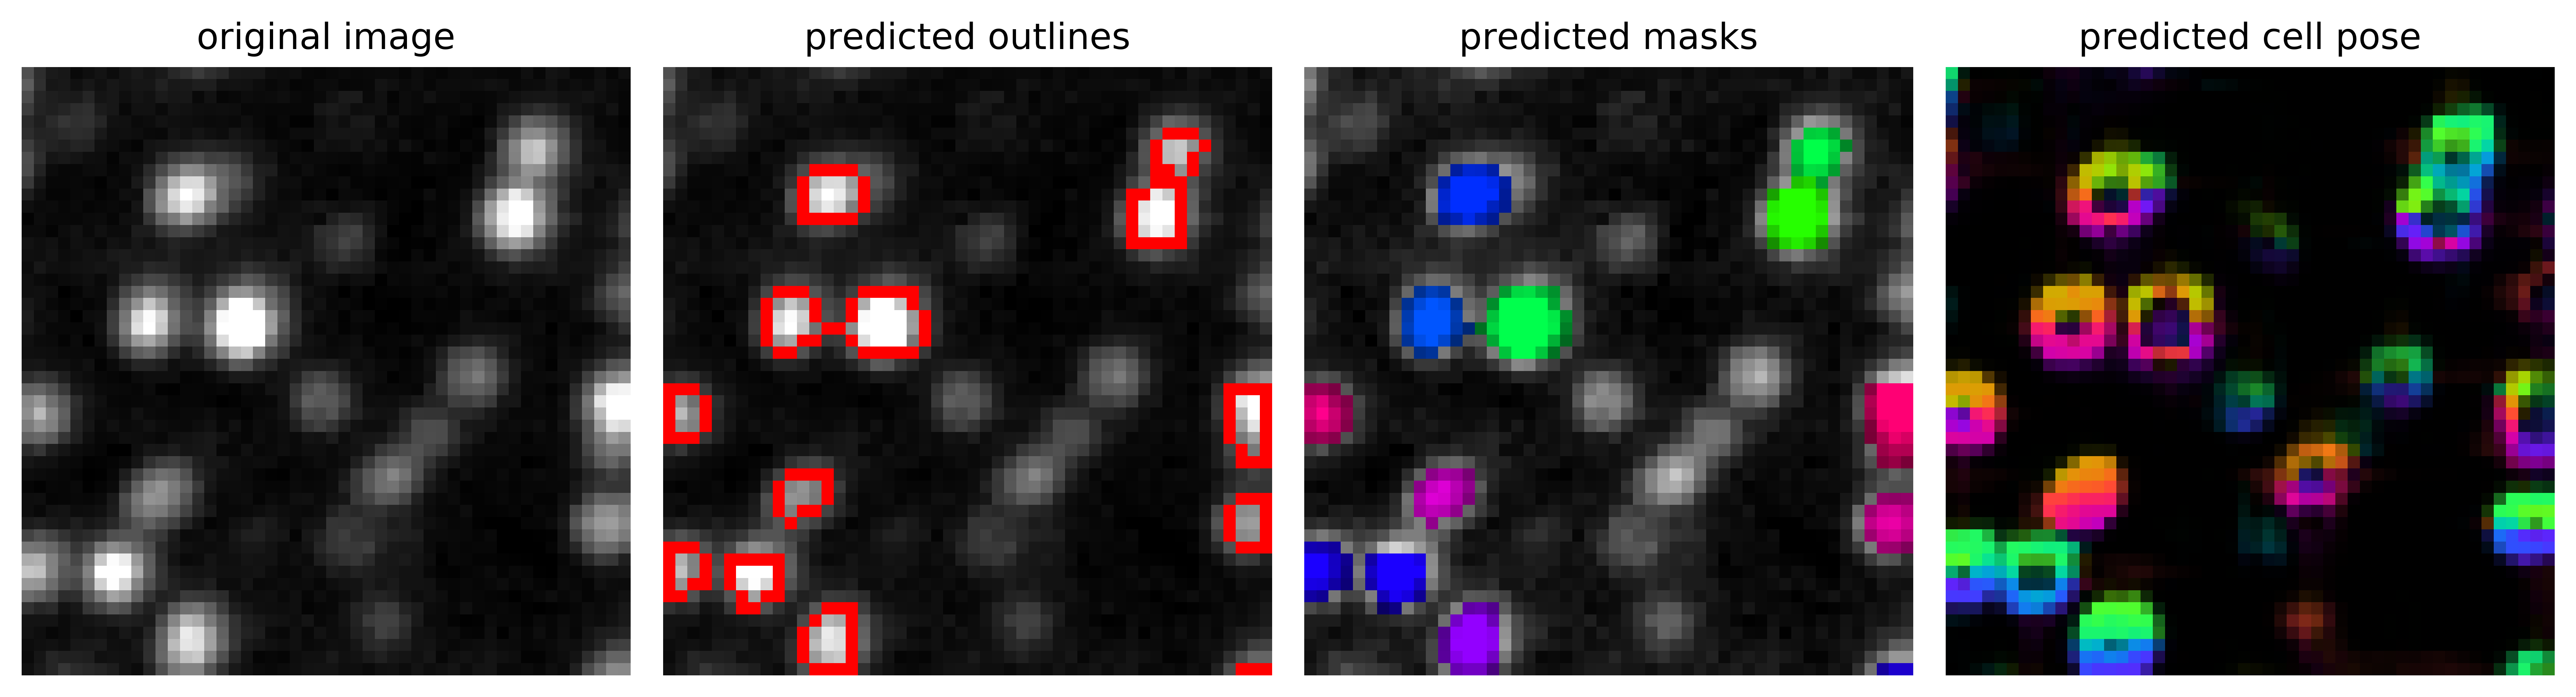

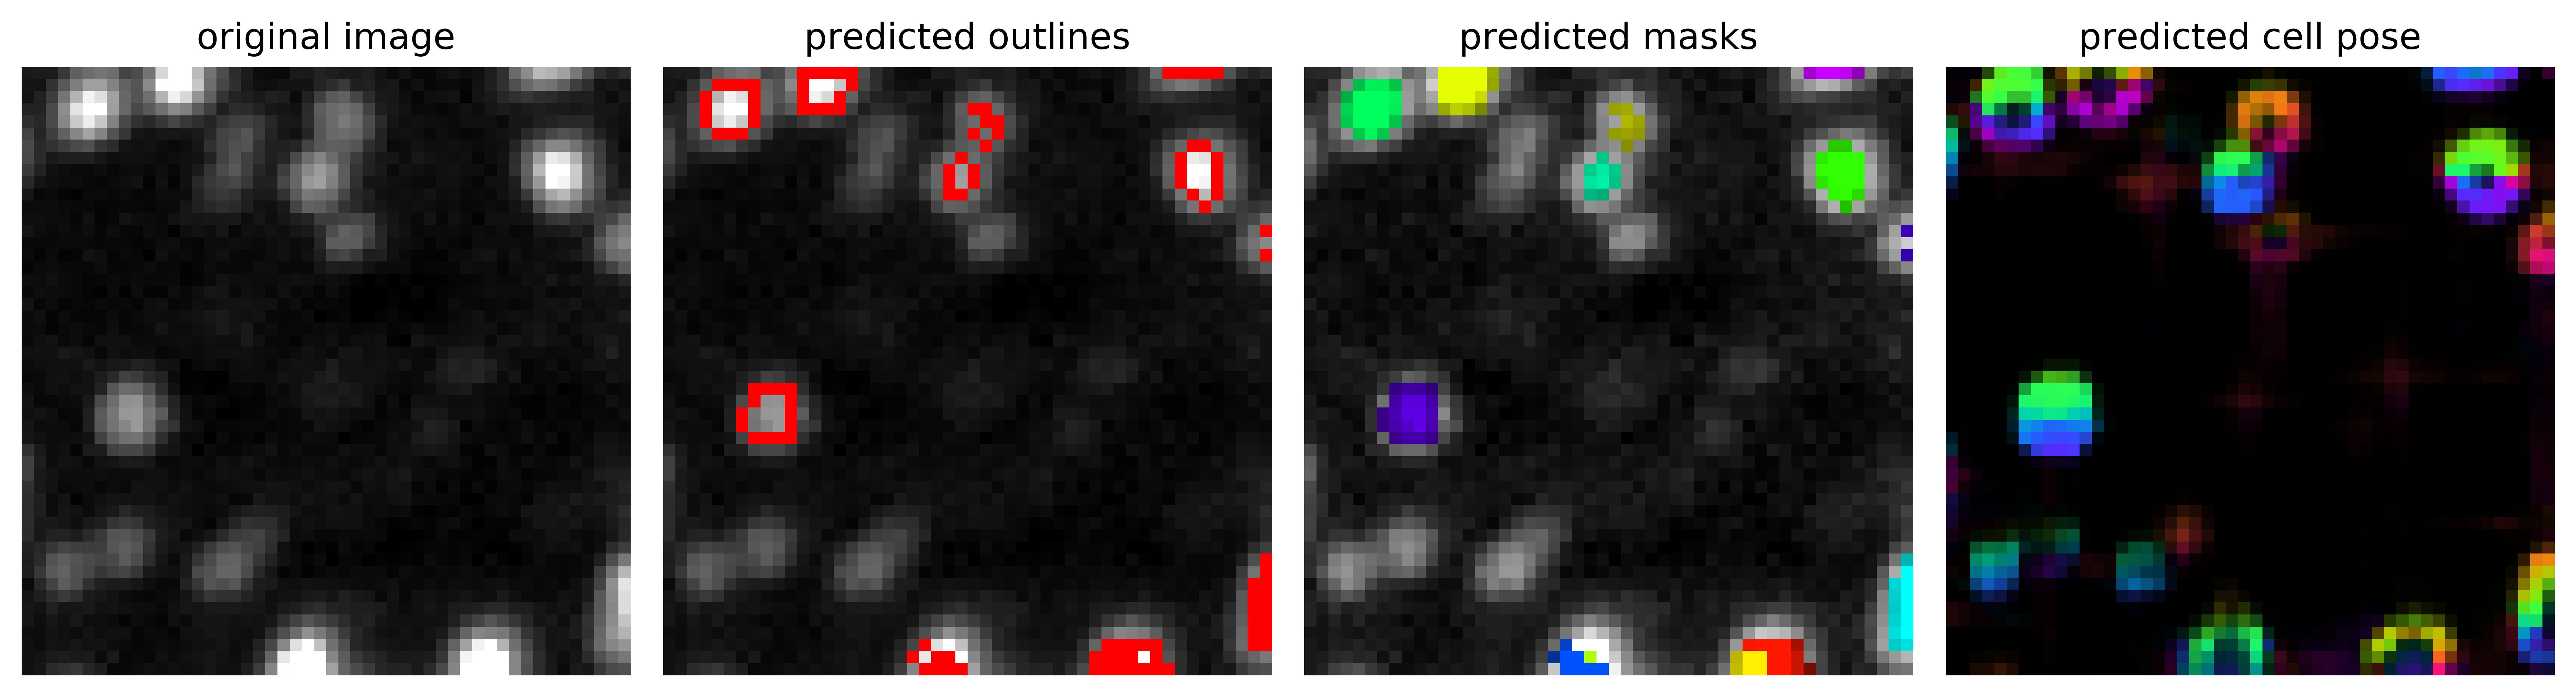

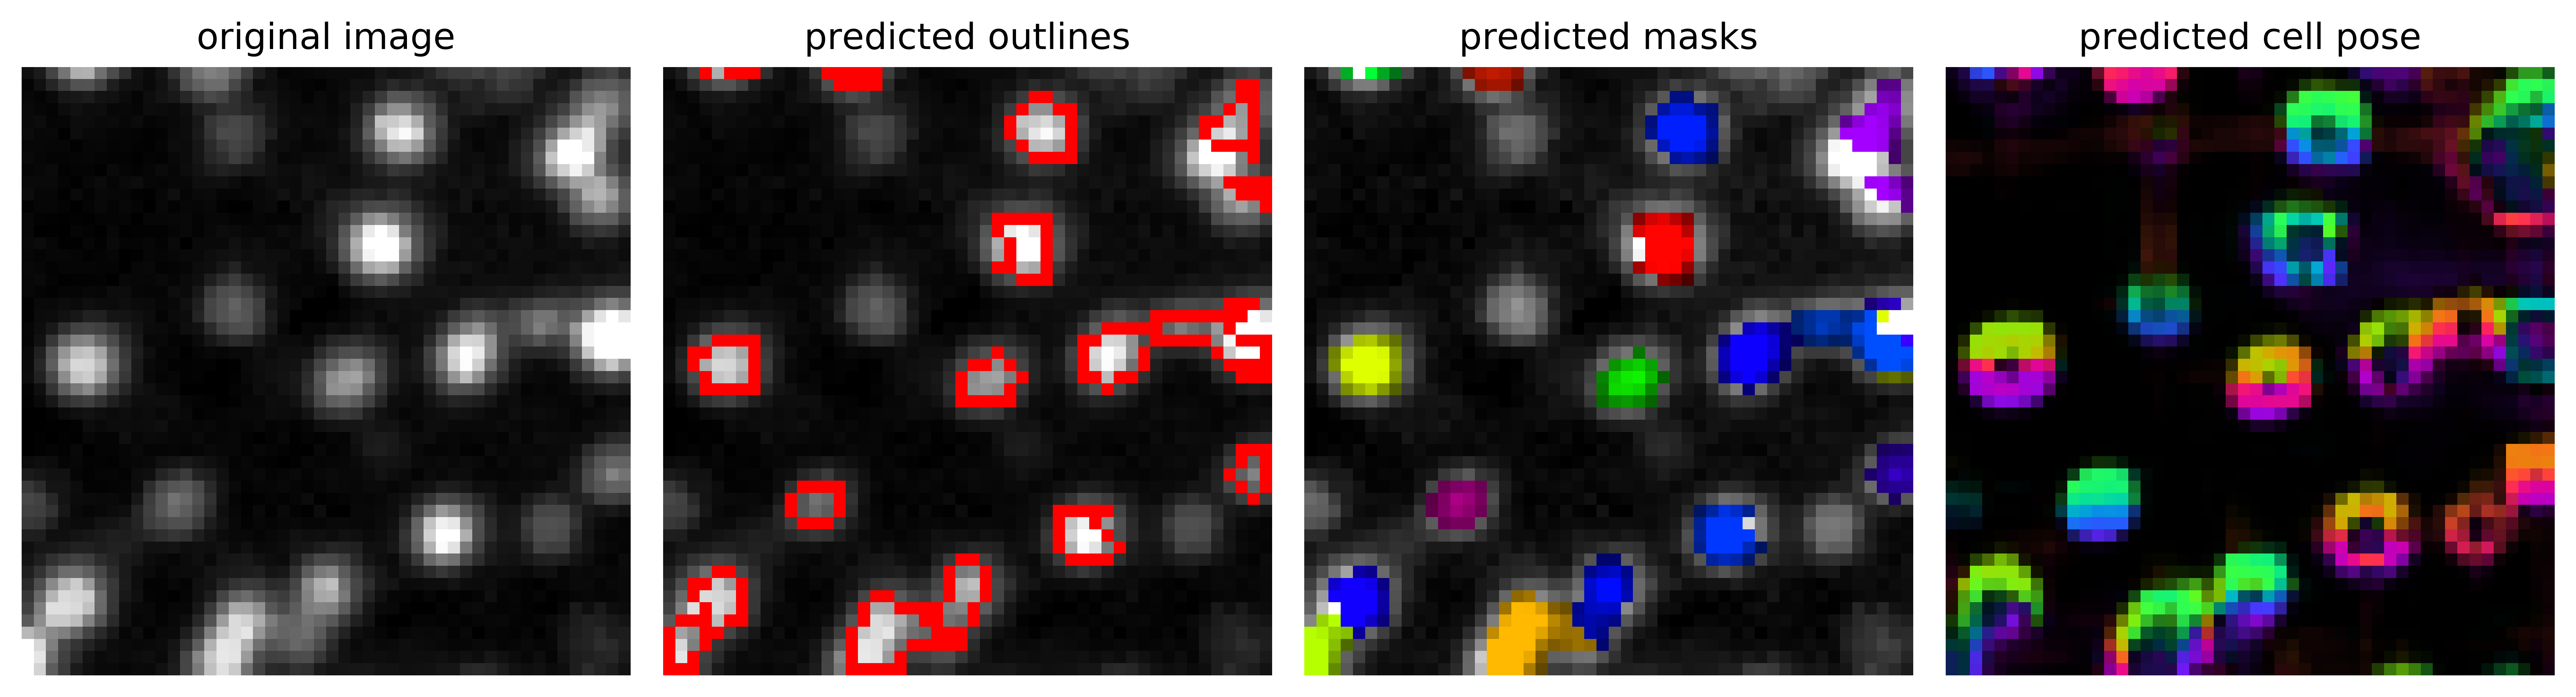

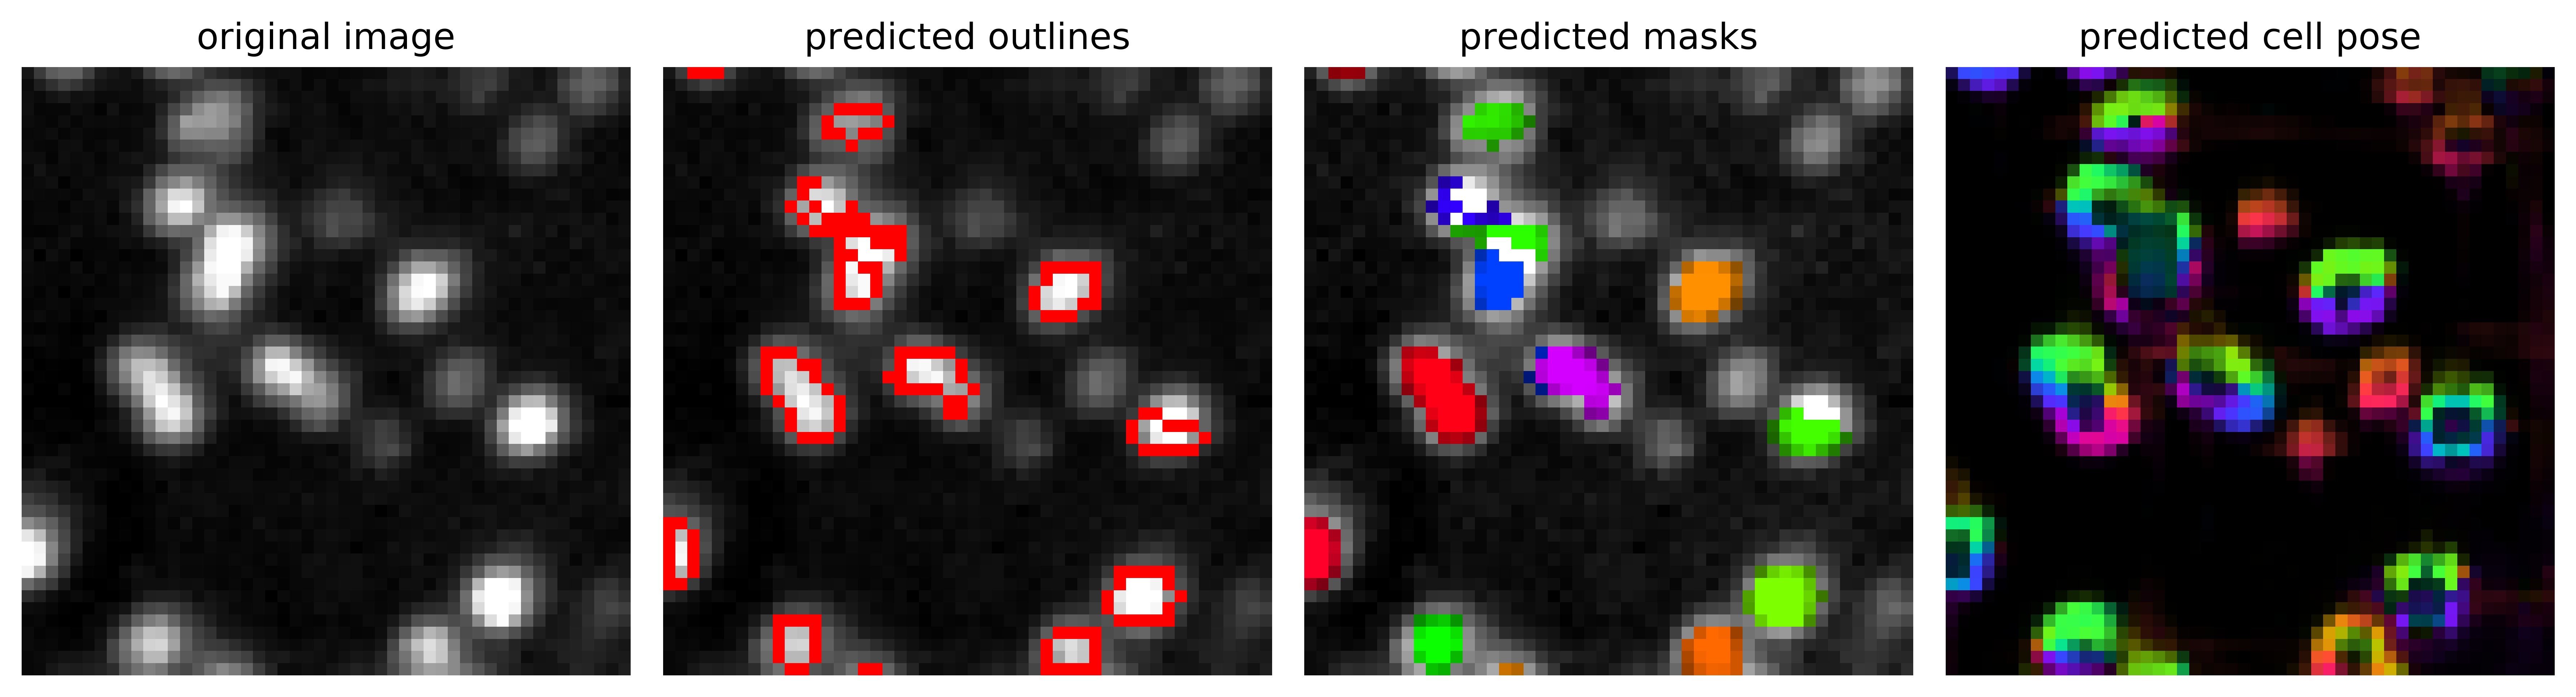

In [15]:
# plot output from 3D flows => masks
from cellpose import plot, utils
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 600

seg_path = os.path.join(output_root, 'flow','block_4_signal_seg.npy') 
seg_data = np.load(seg_path, allow_pickle=True).item()

img = seg_data['img']
masks = seg_data['masks']
flows = seg_data['flows']

crop = [100, 150]

#plot cells with masks
for idx in range(60,91,10):
    maski = masks[idx, crop[0]:crop[1], crop[0]:crop[1]]
    flowi = flows[0][idx, crop[0]:crop[1], crop[0]:crop[1]]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img[idx, crop[0]:crop[1], crop[0]:crop[1]], maski, flowi)
    plt.tight_layout()
    plt.show()